In [1]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = 'cpu'

# import RTRBM

In [23]:
rtrbm = torch.load(open('D:/RU/OneDrive/Intern/rtrbm_master/data/Surrogate data/Reconstructing an RTRBM by hidden trace trained, HT=1, mom=0.7, wc=0.0002, lr=1e-3, lr_end=1e-5, start_decay=200, sp=3e-5, x=2, 2', 'rb'), map_location=torch.device('cpu'))
rtrbm_init = torch.load(open('D:/RU/OneDrive/Intern/rtrbm_master/data/Surrogate data/Reconstructing an RTRBM by hidden trace initial, HT=1, mom=0.7, wc=0.0002, lr=1e-3, lr_end=1e-5, start_decay=200, sp=3e-5, x=2, 2', 'rb'), map_location=torch.device('cpu'))
rbm = torch.load(open('D:/RU/OneDrive/Intern/rtrbm_master/data/Surrogate data/Reconstructing an RBM by hidden trace trained, HT=1, mom=0.7, wc=0.0002, lr=1e-3, lr_end=1e-5, start_decay=200, sp=3e-5, x=2, 1', 'rb'), map_location=torch.device('cpu'))
dataset = pickle.load(open(r'D:\RU\OneDrive\Intern\rtrbm_master\data\Surrogate data\Hidden_trace_' + str(1), 'rb'))
[N, C_E, C_I, EI, IE, resolution, T, dt, T_step, spikes_true, spikes_train, spike_thres, I_inj, V] = dataset
hidden_trace = torch.tensor(1.0 * (spikes_train > spike_thres)).float()
rbm.device = device
rtrbm.device = device

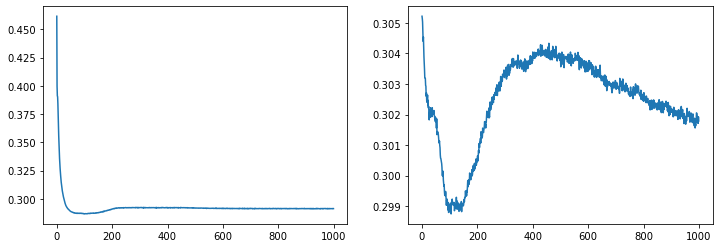

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(rtrbm.errors)
ax[1].plot(rbm.errors)


<AxesSubplot:>

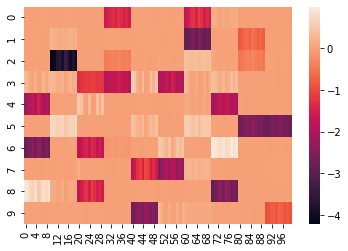

In [25]:
sns.heatmap(rtrbm.W)

# Traces

In [26]:
data = rtrbm.V
N_V, T, n_samples = data.shape
N_H = 10

In [27]:
n_batches = 10
vt_infer_rbm = torch.zeros(N_V, T, n_batches)
rt_infer_rbm = torch.zeros(N_H, T, n_batches)

vt_infer_rtrbm = torch.zeros(N_V, T, n_batches)
rt_infer_rtrbm = torch.zeros(N_H, T, n_batches)

for batch in tqdm(range(n_batches)):
    v_start = (torch.rand(N_V) > 0.2)*1.0
    vt_infer_rbm[:, :, batch], rt_infer_rbm[:, :, batch] = rbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)
    vt_infer_rtrbm[:, :, batch], rt_infer_rtrbm[:, :, batch] = rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)

ht_infer_rbm = (torch.bernoulli(rt_infer_rbm) - 1) * -1
ht_infer_rtrbm = (torch.bernoulli(rt_infer_rtrbm) - 1) * -1

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.11s/it]


AttributeError: 'numpy.ndarray' object has no attribute 'spines'

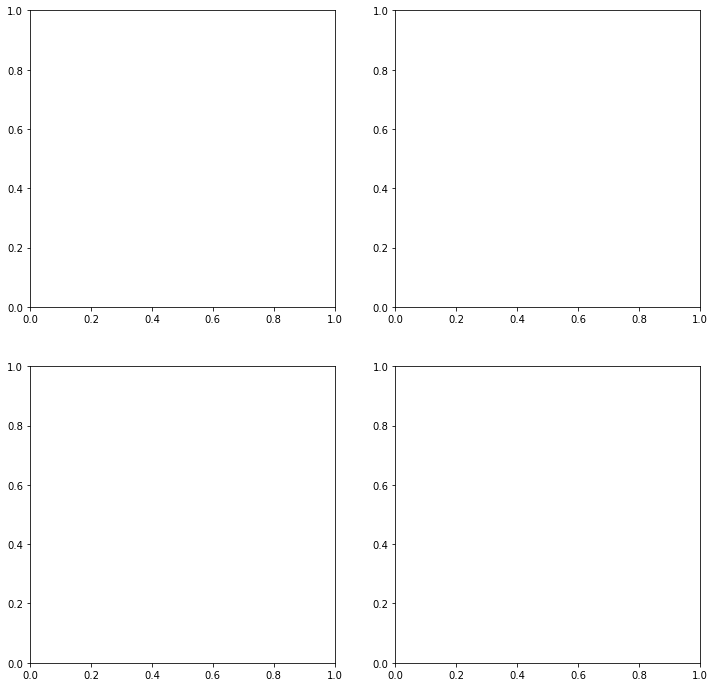

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
colors = ['white', 'black']
cmap = LinearSegmentedColormap.from_list('', colors, 2)

sns.heatmap(data[:, :, 0], ax=ax[0], cbar=False, cmap=cmap, xticklabels=400)
sns.heatmap(vt_infer_rbm[:, :, 0], ax=ax[1], cbar=False, cmap=cmap, xticklabels=400)

ax[0, 0].set_ylabel('$v_{train}$', fontsize=28)
ax[0, 0].tick_params(axis='y', colors='#C55A11')
ax[0, 0].yaxis.label.set_color('#C55A11')

ax[0, 1].set_ylabel('$v_{inferred}$', fontsize=28)
ax[0, 1].tick_params(axis='y', colors='#C55A11')
ax[0, 1].yaxis.label.set_color('#C55A11')
ax[0, 0].set_title('Rasterplots visible units', fontsize=28)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.heatmap(hidden_trace, ax=ax[0], cbar=False, cmap=cmap, xticklabels=400)
sns.heatmap(ht_infer_rbm[:, :, 0], ax=ax[1], cbar=False, cmap=cmap, xticklabels=400)

ax[1, 0].set_ylabel('$H_{train}$', fontsize=28)
ax[1, 0].tick_params(axis='y', colors='#2F5597')
ax[1, 0].yaxis.label.set_color('#2F5597')

ax[1, 1].set_ylabel('$H_{inferred}$', fontsize=28)
ax[1, 1].tick_params(axis='y', colors='#2F5597')
ax[1, 1].yaxis.label.set_color('#2F5597')

ax[1, 0].set_title('Rasterplots hidden units', fontsize=28)
plt.xlabel('Time', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=10)
#plt.savefig(r'D:\RU\OneDrive\Intern\rtrbm_master\figures\Rasterplot_traces_rbm.png', dpi=500)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
colors = ['white', 'black']
cmap = LinearSegmentedColormap.from_list('', colors, 2)

sns.heatmap(data[:, :, 0], ax=ax[0], cbar=False, cmap=cmap, xticklabels=400)
sns.heatmap(vt_infer_rtrbm[:, :, 0], ax=ax[1], cbar=False, cmap=cmap, xticklabels=400)

ax[0].set_ylabel('$v_{train}$', fontsize=28)
ax[0].tick_params(axis='y', colors='#C55A11')
ax[0].yaxis.label.set_color('#C55A11')

ax[1].set_ylabel('$v_{inferred}$', fontsize=28)
ax[1].tick_params(axis='y', colors='#C55A11')
ax[1].yaxis.label.set_color('#C55A11')
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.heatmap(hidden_trace, ax=ax[0], cbar=False, cmap=cmap, xticklabels=400)
sns.heatmap(ht_infer_rtrbm[:, :, 0], ax=ax[1], cbar=False, cmap=cmap, xticklabels=400)

ax[0].set_ylabel('$H_{train}$', fontsize=28)
ax[0].tick_params(axis='y', colors='#2F5597')
ax[0].yaxis.label.set_color('#2F5597')

ax[1].set_ylabel('$H_{inferred}$', fontsize=28)
ax[1].tick_params(axis='y', colors='#2F5597')
ax[1].yaxis.label.set_color('#2F5597')

plt.xlabel('Time', fontsize=28)
ax[0].set_title('Rasterplot visible and hidden units', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=10)
#plt.savefig(r'D:\RU\OneDrive\Intern\rtrbm_master\figures\Rasterplot_traces_rtrbm.png', dpi=500)

# Moments

In [ ]:
n_test_batches = 100
test_data = torch.zeros(N_V, T,  n_test_batches, device=device)

for batch in tqdm(range(n_batches)):
    test_data[:, :, batch] = rtrbm_init.hidden_to_visible(hidden_trace)
    

In [ ]:
plot_compare_moments(rbm, rtrbm, data, test_data, MC_chains=300, chain=50, pre_gibbs_k=50, gibbs_k=20, config_mode=1)

In [ ]:

def plot_compare_moments(rbm, rtrbm, train_data, test_data, MC_chains=300, chain=50, pre_gibbs_k=50, gibbs_k=20, config_mode=1):

    # catenate train and test data
    a = train_data.shape
    if torch.tensor(a).shape[0] == 3:
        V_train = torch.zeros([a[0], a[1] * a[2]])
        for i in range(a[2]):
            V_train[:, a[1] * i: a[1] * (i + 1)] = train_data[:, :, i]
    elif torch.tensor(a).shape[0] == 2:
        V_train = train_data

    s = test_data.shape
    if torch.tensor(s).shape[0] == 3:
        V_test = torch.zeros([s[0], s[1] * s[2]])
        for i in range(s[2]):
            V_test[:, s[1] * i: s[1] * (i + 1)] = test_data[:, :, i]
    elif torch.tensor(s).shape[0] == 2:
        V_test = test_data

    # create figure
    fig, axes = plt.subplots(3, 2, figsize=(10, 20))

    for i, machine in enumerate([rbm, rtrbm]):
        train_data = train_data.detach().clone().to(machine.device)
        test_data = test_data.detach().clone().to(machine.device)
        V_train = V_train.detach().clone().to(machine.device)
        V_test = V_test.detach().clone().to(machine.device)

        for MC_chain in tqdm(range(MC_chains)):
            if config_mode == 1:
                random_train_config = V_train[:, torch.randint(0, V_train.shape[1], (1,))]
                random_train_config = torch.reshape(random_train_config, [V_train.shape[0]])
                v_sampled, h_sampled = machine.sample(random_train_config.T, chain=chain, pre_gibbs_k=pre_gibbs_k,
                                                      gibbs_k=gibbs_k, mode=1, disable_tqdm=True)
            elif config_mode == 2:
                # The train and the test set are defined by chopping the data into batches of T=10 or 100 time samples
                # long. The train_data is the first T*train_data_ratio time samples and the test_data is the remaining
                # part T*(1-train_data_ratio) Therefore, we want to initialize our Monte Carlo chain at the last time
                # step of each train_data batch and sample T*(1-train_data_ratio) time steps to compare it to the
                # test_data.
                start_config = train_data[:, -1, MC_chain].view(train_data.shape[0], 1)
                v_sampled, h_sampled = machine.sample(start_config.T, chain=chain, pre_gibbs_k=pre_gibbs_k,
                                                      gibbs_k=gibbs_k, mode=1, disable_tqdm=True)

            if MC_chain == 0:
                v_samples = v_sampled.detach()
                h_samples = h_sampled.detach()
            else:
                v_samples = torch.cat((v_samples, v_sampled), 1)
                h_samples = torch.cat((h_samples, h_sampled), 1)

        if machine is rbm:
            _, H_test = rbm.visible_to_hidden(V_test)
            #H_test = H_test.T
        elif machine is rtrbm:
            rtrbm_H_test = torch.zeros(rtrbm.N_H, s[1], s[2])
            for j in range(s[2]):
                r = rtrbm.visible_to_expected_hidden(test_data[:, :, j], AF=torch.sigmoid)
                _, rtrbm_H_test[:, :, j] = rtrbm.visible_to_hidden(test_data[:, :, j], r)
            H_test = rtrbm_H_test.view(rtrbm.N_H, s[1] * s[2]).detach()

        means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
        pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
            moments(V_test, H_test, v_samples, h_samples)

        ax = axes[0, i]
        xy = np.vstack([means_V_data, means_V_samples])  # Calculate the point density
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        ax.scatter(means_V_data[idx], means_V_samples[idx], c=z[idx])
        ax.plot([-1, 1], [-1, 1], ':', color='k')
        ax.set_xlim([0, 1]) #ax.set_xlim([torch.min(means_V_data) - 0.1, torch.max(means_V_data) + 0.1])
        ax.set_ylim([0, 1]) #ax.set_ylim([torch.min(means_V_samples) - 0.1, torch.max(means_V_samples) + 0.1])
        # ax.set_aspect('equal', adjustable='box')
        
        ax.set_xlabel('$v_{train}$', fontsize=20)
        ax.tick_params(axis='x', colors='#C55A11')
        ax.xaxis.label.set_color('#C55A11')
        
        ax.set_ylabel('$v_{inferred}$', fontsize=20)
        ax.tick_params(axis='y', colors='#C55A11')
        ax.yaxis.label.set_color('#C55A11')

        ax.set_title("Means $v$, r-value: {:.2f}".format(r_V), fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)

        ax = axes[1, i]
        xy = np.vstack([means_H_data, means_H_samples])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        ax.scatter(means_H_data[idx], means_H_samples[idx], c=z[idx])
        ax.plot([-1, 1], [-1, 1], ':', color='k')
        ax.set_xlim([0, 1]) #ax.set_xlim([torch.min(means_H_data) - 0.1, torch.max(means_H_data) + 0.1])
        ax.set_ylim([0, 1]) #ax.set_ylim([torch.min(means_H_samples) - 0.1, torch.max(means_H_samples) + 0.1])
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('$h_{train}$', fontsize=20)
        ax.tick_params(axis='x', colors='#2F5597')
        ax.xaxis.label.set_color('#2F5597')
        
        ax.set_ylabel('$h_{inferred}$', fontsize=20)
        ax.tick_params(axis='y', colors='#2F5597')
        ax.yaxis.label.set_color('#2F5597')
        ax.set_title("Means H-Units, r-value: {:.2f}".format(r_H), fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)

        ax = axes[2, i]
        xy = np.vstack([pw_VH_data, pw_VH_samples])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        ax.scatter(pw_VH_data[idx], pw_VH_samples[idx], c=z[idx])
        ax.plot([-1, 1], [-1, 1], ':', color='k')
        ax.set_xlim([0, 1]) #ax.set_xlim([torch.min(pw_VH_data) - 0.1, torch.max(pw_VH_data) + 0.1])
        ax.set_ylim([0, 1]) # ax.set_ylim([torch.min(pw_VH_samples) - 0.1, torch.max(pw_VH_samples) + 0.1])
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("$VH_{train}$", fontsize=20)
        ax.set_ylabel("$VH_{inferred}$", fontsize=20)
        ax.set_title("Pairwise moments V/H units, r-value: {:.2f}".format(r_VH), fontsize=28)
        ax.tick_params(axis='both', which='major', labelsize=20)


    fig.tight_layout()
    plt.show()